# **Week 4: Lab Exercises for COMP499/691 Conversational AI**

The goal of this lab is to familiarize yourself with RNN-based Sequence-to-Sequence learning. This is a fundamental learning paradigm that we find in multiple tasks, such as machine translation and speech recognition.

In the tutorial, we implemented RNN-based models from scratch. In this lab, we will implement it using SpeechBrain.


## **Task Description**

A lucky team of archeologists just did an amazing discovery. They found a document reporting some text in English and some text in an ancient language called Ignotush. The archeologists think that for each sentence in English, there is a corresponding translation in the unknown language (parallel corpus).
So far, many documents written in Ignotush have been found, but this is the only document reporting on both Ignotush and English.






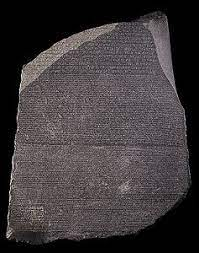

The team of archeologists worked very hard on this document. They hope this document can help translate all the other ones available in Ignotush.

They first contacted a team of linguists, but they had a hard time learning something useful. At some point, one of the archeologists proposed exploring machine learning techniques and contacted you for help with this problem.

**Run the code below** to download the data.

In [3]:
!gdown 1EtiJlE_FT413nIqqh8yiURiuR6d3DSZF
!gdown 1ScPA77G1gu9kh6WKzNyy9h_VgplWisHl
!gdown 19QlNE8u7YPLdzvFh0UexDTLCH51LwgZz

Downloading...
From: https://drive.google.com/uc?id=1EtiJlE_FT413nIqqh8yiURiuR6d3DSZF
To: /content/train.csv
100% 104k/104k [00:00<00:00, 69.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ScPA77G1gu9kh6WKzNyy9h_VgplWisHl
To: /content/valid.csv
100% 20.7k/20.7k [00:00<00:00, 48.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=19QlNE8u7YPLdzvFh0UexDTLCH51LwgZz
To: /content/test.csv
100% 20.9k/20.9k [00:00<00:00, 49.8MB/s]


Use dropbox, if download from gdrive does not work:

In [4]:
%%capture
!wget -O train.csv  https://www.dropbox.com/scl/fi/tokbl3vuy20e46x3udvrm/train.csv?rlkey=6xig36d642ch0n31qk8drm3ry&dl=0
!wget -O valid.csv  https://www.dropbox.com/scl/fi/q0zxf2digbuzy8xozqq1z/valid.csv?rlkey=57hma3bj2et87puc88k1coei1&dl=0
!wget -O test.csv   https://www.dropbox.com/scl/fi/pq7goblr0xfkoyn7utj1g/test.csv?rlkey=8pv3c2agjml2yyy8mi39h676k&dl=0

The dataset is split into training, validation, and test data as you can see by opening `train.csv`, `valid.csv`, and `test.csv`.

For every sentence in English, you have the corresponding sentence in Ignotush.

We have 1000 sentences for training, 200 for validation, and 200 for testing.

This problem is very popular in machine learning and it is called *machine translation* (the famous Google Translate uses deep learning techniques not too far away from those that we will use in this lab).

## **Exercise 1: RNN-based sequence-to-sequence learning**

Fortunately, you studied some sequence-to-sequence learning and you wanted to start with a simple RNN-based encoder-decoder architecture.

Your goal is to implement with [SpeechBrain](https://github.com/speechbrain/speechbrain/) the following architecture:




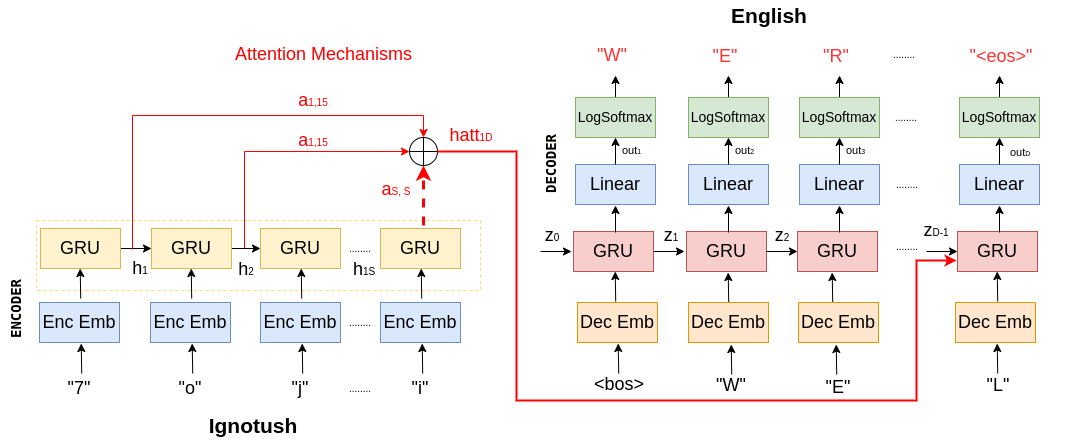

**Run the code below** to install speechbrain.

In [5]:
%%capture
!pip install speechbrain

You wrote the following yaml file that declares all the components that we need.

**Run the code below** to save the hyperparameter file. Please, revise it carefully to start familiarizing yourself with this format.

In [17]:
%%file RNN.yaml

# ############################################################################
# Model: E2E with attention-based Machine Translation
# Encoder: GRU
# Decoder: GRU
# Tokens: Chars
# losses: NLL
# Training: Ignotush
##############################################################################

# Seed needs to be set at top of yaml, before objects with parameters are instantiated
seed: 1986
__set_seed: !apply:torch.manual_seed [!ref <seed>]

# Folder set up
output_folder: !ref results/RNN/<seed>
wer_file: !ref <output_folder>/wer.txt
save_folder: !ref <output_folder>/save
train_log: !ref <output_folder>/train_log.txt
cer_file: !ref <output_folder>/test_cer.txt # file were to store the final character error rate on the test set.

# Path where data manifest files are stored
train_annotation: train.csv
valid_annotation: valid.csv
test_annotation: test.csv

# The train logger writes training statistics to a file, as well as stdout.
train_logger: !new:speechbrain.utils.train_logger.FileTrainLogger
    save_file: !ref <train_log>

# Training parameters
number_of_epochs: 50
batch_size: 100
lr: 0.01
lr_final: 0.001


# Dataloader options
train_dataloader_opts:
    batch_size: !ref <batch_size>

valid_dataloader_opts:
    batch_size: !ref <batch_size>

test_dataloader_opts:
    batch_size: !ref <batch_size>


# Vocabulary sizes
voc_size_english: 31
voc_size_ignotush: 32

# Indexes for begin-of-sentence (bos)
# and end-of-sentence (eos)
blank_index: 0 # This special tokes is for padding
bos_index: 1
eos_index: 2

# Encoder Parameters
enc_hidden_size: 128
enc_num_layers: 2

# Decoder Parameters
dec_hidden_size: 128
dec_num_layers: 1
attn_dim: 128
dropout: 0.5

# The first object passed to the Brain class is this "Epoch Counter"
# which is saved by the Checkpointer so that training can be resumed
# if it gets interrupted at any point.
epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter
    limit: !ref <number_of_epochs>

# Encoder
encoder: !new:speechbrain.nnet.RNN.GRU
    input_size: !ref <enc_hidden_size>
    hidden_size: !ref <enc_hidden_size>
    num_layers: !ref <enc_num_layers>
    dropout: !ref <dropout>

encoder_emb: !new:torch.nn.Embedding
    num_embeddings: !ref <voc_size_ignotush>
    embedding_dim: !ref <enc_hidden_size>
    padding_idx: !ref <blank_index>

# Attention-based RNN decoder.
decoder: !new:speechbrain.nnet.RNN.AttentionalRNNDecoder
    enc_dim: !ref <enc_hidden_size>
    input_size: !ref <dec_hidden_size>
    rnn_type: gru
    attn_type: content
    hidden_size: !ref <dec_hidden_size>
    attn_dim: !ref <attn_dim>
    num_layers: !ref <dec_num_layers>
    dropout: !ref <dropout>

decoder_emb: !new:torch.nn.Embedding
    num_embeddings: !ref <voc_size_ignotush>
    embedding_dim: !ref <dec_hidden_size>
    padding_idx: !ref <blank_index>

# Linear transformation on the top of the decoder.
seq_lin: !new:speechbrain.nnet.linear.Linear
    input_size: !ref <dec_hidden_size>
    n_neurons: !ref <voc_size_english>

# Final softmax (for log posteriors computation).
log_softmax: !new:speechbrain.nnet.activations.Softmax
    apply_log: True



# Objects in "modules" dict will have their parameters moved to the correct
# device, as well as having train()/eval() called on them by the Brain class
modules:
    encoder: !ref <encoder>
    encoder_emb: !ref <encoder_emb>
    decoder: !ref <decoder>
    decoder_emb: !ref <encoder_emb>
    seq_lin: !ref <seq_lin>


# Gathering all the submodels in a single model object.
model: !new:torch.nn.ModuleList
    - - !ref <encoder>
      - !ref <encoder_emb>
      - !ref <decoder>
      - !ref <seq_lin>
      - !ref <decoder_emb>


# This function manages learning rate annealing over the epochs.
lr_annealing: !new:speechbrain.nnet.schedulers.LinearScheduler
    initial_value: !ref <lr>
    final_value: !ref <lr_final>
    epoch_count: !ref <number_of_epochs>

# This optimizer will be constructed by the Brain class after all parameters
# are moved to the correct device. Then it will be added to the checkpointer.
opt_class: !name:torch.optim.Adam
    lr: !ref <lr>

# This object is used for saving the state of training both so that it
# can be resumed if it gets interrupted, and also so that the best checkpoint
# can be later loaded for evaluation or inference.
checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
    checkpoints_dir: !ref <save_folder>
    recoverables:
        model: !ref <model>
        counter: !ref <epoch_counter>


Overwriting RNN.yaml


The RNN.yaml hyperparameter file is coupled with the following training script (train.py).

**Complete the code below** to implement the targeted system. You have to write your code in the `forward` and `compute_objective` methods where required. The code should match what is declared in the YAML file. Take this opportunity to further familiarize yourself with the SpeechBrain training script (they are all similar). In particular, try to understand the data flow: take a look at how we create and process entries declared in the CSV files, how we turn the sequence of chars into a sequence of corresponding integers,  how we turn the processed entries into batches, etc.

In [18]:
%%file train.py

#!/usr/bin/env/python3
"""Recipe for training a sequence-to-sequence machine translation system
on "ignotush".
The system employs an encoder, a decoder, and an attention mechanism
between them.

To run this recipe, do the following:
> python train.py train.yaml

With the default hyperparameters, the system employs an GRU encoder and decoder.

The neural network is trained with the negative-log likelihood objective and
characters are used as basic tokens for both english and ignotush.
"""

import os
import sys
import torch
import logging
import speechbrain as sb
from hyperpyyaml import load_hyperpyyaml

logger = logging.getLogger(__name__)


# Brain class for speech recognition training
class Translate(sb.Brain):
    """Class that manages the training loop. See speechbrain.core.Brain."""

    def compute_forward(self, batch, stage):
        """Runs all the computation of the CTC + seq2seq ASR. It returns the
        posterior probabilities of the CTC and seq2seq networks.

        Arguments
        ---------
        batch : PaddedBatch
            This batch object contains all the relevant tensors for computation.
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, or sb.Stage.TEST.

        Returns
        -------
        predictions : torch.tensor
            Log-probabilities predicted by the decoder.

        At validation/test time, it returns the predicted tokens as well.
        """
        # We first move the batch to the appropriate device.
        # Your code here. Aim for 1 line
        batch = batch.to(self.device)

        # Unpacking inputs
        # Your code here. Aim for 1 line
        enc_ignotush , inp_lens= batch.ignotush_encoded_chars.data, batch.ignotush_encoded_chars.lengths

        # print("Initial Input and length of the ignotush:")
        # print(enc_ignotush.shape)
        # print(inp_lens)

        # Input embeddings
        # Your code here. Aim for 1 line
        enc_emb = self.modules.encoder_emb(enc_ignotush)

        # print("Encoder embedding shape:")
        # print(enc_emb.shape)

        # Running the encoder
        # Your code here. Aim for 1 line
        encoded_signal, _ = self.modules.encoder(enc_emb, lengths=inp_lens)

        # print("Encoder Signal shape:")
        # print(encoded_signal.shape)

        # Unpacking Labels
        # Your code here. Aim for 1 line
        enc_english_bos , inp_lens = batch.english_encoded_chars_bos.data , batch.english_encoded_chars_bos.lengths

        # Decoding Embeddings
        # Your code here. Aim for 1 line
        dec_emb = self.modules.decoder_emb(enc_english_bos)

        # print("Decoder embedding shape: ")
        # print(dec_emb.shape)

        # Running the decoder
        # Your code here. Aim for 1 line

        # print("oooooooooooooooooooo: ")
        # print(inp_lens.shape)
        # print(dec_emb.shape)


        decoder_outputs, _ = self.modules.decoder(dec_emb,encoded_signal,inp_lens)

        # Compute logits (i.e., apply final linear transformation)
        # Your code here. Aim for 1 line
        logits = self.modules.seq_lin(decoder_outputs)

        # Compute log posteriors
        # Your code here. Aim for 1 line
        predictions = self.hparams.log_softmax(logits)

        if stage == sb.Stage.TEST:

            # Getting Some predictions.
            # Note: For simplicity we use teacher forcing also for testing.
            # For a real inference, you would need to implement greedy search
            # and feed into the autoregressive model the actual predictions
            # done at each step by the model.
            hyps = predictions.argmax(-1)

            # getting the first index where the prediciton is eos_index
            stop_indexes = (hyps==self.hparams.eos_index).int()
            stop_indexes = stop_indexes.argmax(dim=1)

            # Converting hyps from indexes to chars
            hyp_lst = []
            for hyp, stop_ind in zip(hyps, stop_indexes):
                # in some cases the eos in not observed (e.g, for the last sentence
                # in the batch)
                if stop_ind == 0:
                    stop_ind = -1
                # Stopping when eos is observed
                hyp = hyp[0:stop_ind]
                # From index to character
                hyp_lst.append(self.label_encoder.decode_ndim(hyp))

            return predictions, hyp_lst

        return predictions


    def compute_objectives(self, predictions, batch, stage):
        """Computes the loss given the predicted and targeted outputs.

        Arguments
        ---------
        predictions : torch.tTensor
            The output tensor from `compute_forward`.
        batch : PaddedBatch
            This batch object contains all the relevant tensors for computation.
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, or sb.Stage.TEST.

        Returns
        -------
        loss : torch.Tensor
            A one-element tensor used for backpropagating the gradient.
        """
        # Unpacking Labels with eos
        # Your code here. Aim for 1 line
        enc_english_eos, english_lens = batch.english_encoded_chars_eos.data, batch.english_encoded_chars_eos.lengths

        # print(enc_english_eos.shape)
        # print(predictions.shape)

        # Reading the predictions
        if stage == sb.Stage.TEST:
          predictions, hyp_lst = predictions

          for id, inp, label, hyp in zip(batch.id, batch.ignotush_chars, batch.english_chars, hyp_lst):
              print(id)
              print("INP: " + ''.join(inp))
              print("REF: " + ''.join(label))
              print("HYP: " + ''.join(hyp))
              print('--------')

        # Computing the nll_loss
        # Your code here. Aim for 1 line
        loss = sb.nnet.losses.nll_loss(predictions,enc_english_eos,english_lens)

        return loss


    def on_stage_end(self, stage, stage_loss, epoch):
        """Gets called at the end of an epoch.

        Arguments
        ---------
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, sb.Stage.TEST
        stage_loss : float
            The average loss for all of the data processed in this stage.
        epoch : int
            The currently-starting epoch. This is passed
            `None` during the test stage.
        """

        # Store the train loss until the validation stage.
        stage_stats = {"loss": stage_loss}
        if stage == sb.Stage.TRAIN:
            self.train_stats = stage_stats


        # Perform end-of-iteration things, like annealing, logging, etc.
        elif stage == sb.Stage.VALID:


            # Update learning rate
            old_lr, new_lr = self.hparams.lr_annealing(epoch)
            sb.nnet.schedulers.update_learning_rate(self.optimizer, new_lr)

            # The train_logger writes a summary to stdout and to the logfile.
            self.hparams.train_logger.log_stats(
                stats_meta={"epoch": epoch, "lr": old_lr},
                train_stats=self.train_stats,
                valid_stats={
                    "loss": stage_loss,
                },
            )
            # Save the current checkpoint and delete previous checkpoints.
            self.checkpointer.save_and_keep_only(
                meta={"loss": stage_stats["loss"]}, min_keys=["loss"],
            )

        # We also write statistics about test data to stdout and to the logfile.
        elif stage == sb.Stage.TEST:

            self.hparams.train_logger.log_stats(
                stats_meta={"Epoch loaded": self.hparams.epoch_counter.current},
                test_stats={
                    "loss": stage_loss,
                },
            )


def dataio_prepare(hparams):
    """This function prepares the datasets to be used in the brain class.
    It also defines the data processing pipeline through user-defined functions.


    Arguments
    ---------
    hparams : dict
        This dictionary is loaded from the `train.yaml` file, and it includes
        all the hyperparameters needed for dataset construction and loading.

    Returns
    -------
    datasets : dict
        Dictionary containing "train", "valid", and "test" keys that correspond
        to the DynamicItemDataset objects.
    """
    # Define text processing pipeline. We start from the raw text and then
    # split it into characters. The tokens with BOS are used for feeding
    # the decoder during training (right shifr), the tokens with EOS
    # are used for computing the cost function.
    @sb.utils.data_pipeline.takes("english")
    @sb.utils.data_pipeline.provides(
        "english_words",
        "english_chars",
        "english_encoded_chars_lst",
        "english_encoded_chars",
        "english_encoded_chars_eos",
        "english_encoded_chars_bos",
        )
    def ignotush_text_pipeline(english):
        """Processes the transcriptions to generate proper labels"""
        yield english
        english_chars = list(english)
        yield english_chars
        english_encoded_chars_lst = label_encoder.encode_sequence(english_chars)
        yield english_encoded_chars_lst
        english_encoded_chars = torch.LongTensor(english_encoded_chars_lst)
        yield english_encoded_chars
        english_encoded_chars_eos = torch.LongTensor(label_encoder.append_eos_index(english_encoded_chars_lst))
        yield english_encoded_chars_eos
        english_encoded_chars_bos = torch.LongTensor(label_encoder.prepend_bos_index(english_encoded_chars_lst))
        yield english_encoded_chars_bos

    @sb.utils.data_pipeline.takes("ignotush")
    @sb.utils.data_pipeline.provides("ignotush_words", "ignotush_chars", "ignotush_encoded_chars")
    def english_text_pipeline(ignotush):
        """Processes the transcriptions to generate proper labels"""
        yield ignotush
        ignotush_chars = list(ignotush)
        yield ignotush_chars
        ignotush_encoded_chars = torch.LongTensor(input_encoder.encode_sequence(ignotush_chars))
        yield ignotush_encoded_chars

    # Define datasets from json data manifest file
    # Define datasets sorted by ascending lengths for efficiency
    datasets = {}
    data_info = {
        "train": hparams["train_annotation"],
        "valid": hparams["valid_annotation"],
        "test": hparams["test_annotation"],
    }

    # The label encoder will assign a different integer to each element
    # in the output vocabulary
    input_encoder = sb.dataio.encoder.CTCTextEncoder()
    label_encoder = sb.dataio.encoder.CTCTextEncoder()

    for dataset in data_info:
        datasets[dataset] = sb.dataio.dataset.DynamicItemDataset.from_csv(
            csv_path=data_info[dataset],
            dynamic_items=[ignotush_text_pipeline, english_text_pipeline],
            output_keys=[
                "id",
                "english_words",
                "english_chars",
                "english_encoded_chars",
                "english_encoded_chars_eos",
                "english_encoded_chars_bos",
                "ignotush_words",
                "ignotush_chars",
                "ignotush_encoded_chars",
            ],
        )
        hparams[f"{dataset}_dataloader_opts"]["shuffle"] = True


    # Load or compute the label encoder
    inp_enc_file = os.path.join(hparams["save_folder"], "input_encoder.txt")

    # The blank symbol is used to indicate padding
    special_labels = {"blank_label": hparams["blank_index"]}

    input_encoder.load_or_create(
        path=inp_enc_file,
        from_didatasets=[datasets["train"]],
        output_key="ignotush_chars",
        special_labels=special_labels,
        sequence_input=True,
    )

    # Load or compute the label encoder
    lab_enc_file = os.path.join(hparams["save_folder"], "label_encoder.txt")
    special_labels = {
        "blank_label": hparams["blank_index"],
        "bos_label": hparams["bos_index"],
        "eos_label": hparams["eos_index"],
    }
    label_encoder.load_or_create(
        path=lab_enc_file,
        from_didatasets=[datasets["train"]],
        output_key="english_chars",
        special_labels=special_labels,
        sequence_input=True,
    )

    return datasets, label_encoder


if __name__ == "__main__":

    # Reading command line arguments
    hparams_file, run_opts, overrides = sb.parse_arguments(sys.argv[1:])

    # Load hyperparameters file with command-line overrides
    with open(hparams_file) as fin:
        hparams = load_hyperpyyaml(fin, overrides)

    # Create experiment directory
    sb.create_experiment_directory(
        experiment_directory=hparams["output_folder"],
        hyperparams_to_save=hparams_file,
        overrides=overrides,
    )


    # We can now directly create the datasets for training, valid, and test
    datasets, label_encoder = dataio_prepare(hparams)

    # Trainer initialization
    translate_brain = Translate(
        modules=hparams["modules"],
        opt_class=hparams["opt_class"],
        hparams=hparams,
        run_opts=run_opts,
        checkpointer=hparams["checkpointer"],
    )

    # Making label encoder accessible (needed for computer the character error rate)
    translate_brain.label_encoder = label_encoder

    # The `fit()` method iterates the training loop, calling the methods
    # necessary to update the parameters of the model. Since all objects
    # with changing state are managed by the Checkpointer, training can be
    # stopped at any point, and will be resumed on next call.
    translate_brain.fit(
        translate_brain.hparams.epoch_counter,
        datasets["train"],
        datasets["valid"],
        train_loader_kwargs=hparams["train_dataloader_opts"],
        valid_loader_kwargs=hparams["valid_dataloader_opts"],
    )

    # Load best checkpoint for evaluation
    test_stats = translate_brain.evaluate(
        test_set=datasets["test"],
        min_key="WER",
        test_loader_kwargs=hparams["test_dataloader_opts"],
    )


Overwriting train.py


**Run the code below** to start training. We here use a CPU because the task is pretty fast. It might take 10-15 minutes to train the RNN model.

In [21]:
!rm -rf ./results
!python train.py RNN.yaml --device='cpu'

INFO:speechbrain.utils.quirks:Applied quirks (see `speechbrain.utils.quirks`): [disable_jit_profiling, allow_tf32]
INFO:speechbrain.utils.quirks:Excluded quirks specified by the `SB_DISABLE_QUIRKS` environment (comma-separated list): []
speechbrain.utils.quirks - Applied quirks (see `speechbrain.utils.quirks`): [disable_jit_profiling, allow_tf32]
speechbrain.utils.quirks - Excluded quirks specified by the `SB_DISABLE_QUIRKS` environment (comma-separated list): []
speechbrain.core - Beginning experiment!
speechbrain.core - Experiment folder: results/RNN/1986
speechbrain.dataio.encoder - Moving label 'p' from index 0, because '<blank>' was put at its place.
speechbrain.dataio.encoder - Load called, but CTCTextEncoder is not empty. Loaded data will overwrite everything. This is normal if there is e.g. an unk label defined at init.
speechbrain.dataio.encoder - Moving label 'T' from index 0, because '<blank>' was put at its place.
speechbrain.dataio.encoder - Moving label 'H' from index 1, 

At test time, we print both hypotheses and references. If everything works well, you should have learned a very plausible translation from Ingnotush to English:




```
snt136
INP: pojiohtta8tthah94poozattzya7ttm6ttaho7ozpooz
REF: TERESA WAS SIXTEEN AND VAMPA SEVENTEEN
HYP: TERESA WAS SIXTEEN AND VAMPA SEVENTEEN
--------
snt152
INP: 39ha3ottjipattqp95za9ha6jioppfa8ottxnao7ozafop
REF: HIS HEART ACTION IS PRETTY WEAK EVEN YET
HYP: HIS HEART ACTION IS PRETTY WEAK EVEN YET
--------
snt103
INP: 2ooa2ooap3oa1ji52a3566oyaho7ojittklap9moh
REF: GEE GEE THE FROG HOPPED SEVERAL TIMES
HYP: GEE GEE THE FROG HOPPED SEVERAL TIMES
--------
```



Note that some small artifacts in the translation are still possible (e.g., repeating the last character multiple times) because we are using a very simple system. Nevertheless, on average, the quality should be really good.

Your `train_log.txt` file (see `results/RNN/1986/train_log.txt`) should look like this:



```
epoch: 1, lr: 1.00e-02 - train loss: 3.58 - valid loss: 2.61
epoch: 2, lr: 9.82e-03 - train loss: 2.45 - valid loss: 2.30
epoch: 3, lr: 9.63e-03 - train loss: 2.25 - valid loss: 2.15
epoch: 4, lr: 9.45e-03 - train loss: 2.11 - valid loss: 2.03
epoch: 5, lr: 9.27e-03 - train loss: 1.98 - valid loss: 1.87
epoch: 6, lr: 9.08e-03 - train loss: 1.78 - valid loss: 1.54
epoch: 7, lr: 8.90e-03 - train loss: 1.32 - valid loss: 7.07e-01
epoch: 8, lr: 8.71e-03 - train loss: 6.72e-01 - valid loss: 2.80e-01
epoch: 9, lr: 8.53e-03 - train loss: 3.74e-01 - valid loss: 1.54e-01
epoch: 10, lr: 8.35e-03 - train loss: 2.61e-01 - valid loss: 1.23e-01
epoch: 11, lr: 8.16e-03 - train loss: 2.06e-01 - valid loss: 1.01e-01
epoch: 12, lr: 7.98e-03 - train loss: 1.62e-01 - valid loss: 7.95e-02
epoch: 13, lr: 7.80e-03 - train loss: 1.51e-01 - valid loss: 7.01e-02
epoch: 14, lr: 7.61e-03 - train loss: 1.29e-01 - valid loss: 6.27e-02
epoch: 15, lr: 7.43e-03 - train loss: 1.11e-01 - valid loss: 5.58e-02
epoch: 16, lr: 7.24e-03 - train loss: 1.04e-01 - valid loss: 4.95e-02
epoch: 17, lr: 7.06e-03 - train loss: 9.31e-02 - valid loss: 4.60e-02
epoch: 18, lr: 6.88e-03 - train loss: 7.69e-02 - valid loss: 4.27e-02
epoch: 19, lr: 6.69e-03 - train loss: 7.32e-02 - valid loss: 4.72e-02
epoch: 20, lr: 6.51e-03 - train loss: 7.17e-02 - valid loss: 4.22e-02
epoch: 21, lr: 6.33e-03 - train loss: 6.75e-02 - valid loss: 3.27e-02
epoch: 22, lr: 6.14e-03 - train loss: 6.18e-02 - valid loss: 3.40e-02
epoch: 23, lr: 5.96e-03 - train loss: 5.32e-02 - valid loss: 2.78e-02
epoch: 24, lr: 5.78e-03 - train loss: 4.97e-02 - valid loss: 2.99e-02
epoch: 25, lr: 5.59e-03 - train loss: 4.88e-02 - valid loss: 2.89e-02
epoch: 26, lr: 5.41e-03 - train loss: 5.18e-02 - valid loss: 2.99e-02
epoch: 27, lr: 5.22e-03 - train loss: 4.13e-02 - valid loss: 2.57e-02
epoch: 28, lr: 5.04e-03 - train loss: 3.57e-02 - valid loss: 2.55e-02
epoch: 29, lr: 4.86e-03 - train loss: 3.45e-02 - valid loss: 2.48e-02
epoch: 30, lr: 4.67e-03 - train loss: 3.40e-02 - valid loss: 2.41e-02
epoch: 31, lr: 4.49e-03 - train loss: 2.88e-02 - valid loss: 2.13e-02
epoch: 32, lr: 4.31e-03 - train loss: 3.01e-02 - valid loss: 2.03e-02
epoch: 33, lr: 4.12e-03 - train loss: 3.11e-02 - valid loss: 2.36e-02
epoch: 34, lr: 3.94e-03 - train loss: 2.63e-02 - valid loss: 2.00e-02
epoch: 35, lr: 3.76e-03 - train loss: 2.51e-02 - valid loss: 2.31e-02
epoch: 36, lr: 3.57e-03 - train loss: 2.32e-02 - valid loss: 2.09e-02
epoch: 37, lr: 3.39e-03 - train loss: 2.09e-02 - valid loss: 1.98e-02
epoch: 38, lr: 3.20e-03 - train loss: 1.98e-02 - valid loss: 1.86e-02
epoch: 39, lr: 3.02e-03 - train loss: 1.94e-02 - valid loss: 1.81e-02
epoch: 40, lr: 2.84e-03 - train loss: 1.82e-02 - valid loss: 2.12e-02
epoch: 41, lr: 2.65e-03 - train loss: 1.63e-02 - valid loss: 1.88e-02
epoch: 42, lr: 2.47e-03 - train loss: 1.61e-02 - valid loss: 1.79e-02
epoch: 43, lr: 2.29e-03 - train loss: 1.51e-02 - valid loss: 1.49e-02
epoch: 44, lr: 2.10e-03 - train loss: 1.41e-02 - valid loss: 1.71e-02
epoch: 45, lr: 1.92e-03 - train loss: 1.42e-02 - valid loss: 1.71e-02
epoch: 46, lr: 1.73e-03 - train loss: 1.32e-02 - valid loss: 1.60e-02
epoch: 47, lr: 1.55e-03 - train loss: 1.24e-02 - valid loss: 1.56e-02
epoch: 48, lr: 1.37e-03 - train loss: 1.50e-02 - valid loss: 1.56e-02
epoch: 49, lr: 1.18e-03 - train loss: 1.23e-02 - valid loss: 1.49e-02
epoch: 50, lr: 1.00e-03 - train loss: 1.19e-02 - valid loss: 1.46e-02
Epoch loaded: 50 - test loss: 2.90e-02
```




Note that variations to the performance are expected. The most important thing is to get a good test loss (e.g., < 4.00e-02).

We can now plot the training and validation losses stored in the log file.

**Complete the code below** to plot the training and validation curves.

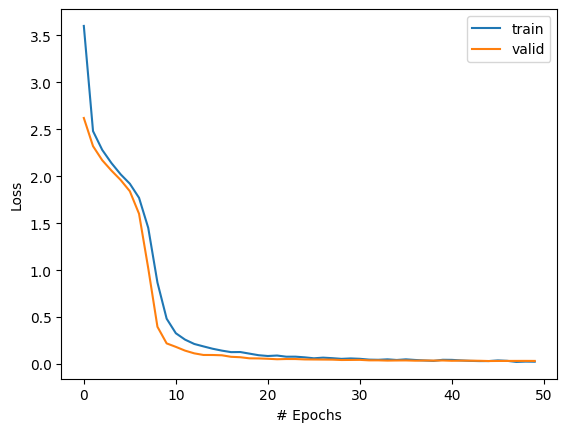

In [22]:
import matplotlib.pyplot as plt

def get_losses(log_file):
  """This function takes in input a path of a log-file and outputs the train and
  valid losses in lists of float numbers"""
  train_losses = []
  valid_losses = []

  with open(log_file, 'r') as f:
    for line in f:
      if 'train loss' and 'valid loss' in line:
        valid_losses.append(float(line.split()[-1]))
        train_losses.append(float(line.split()[-5]))


  # Add a return statement to return the losses
  return train_losses, valid_losses # This line was added to fix the error


log_file = 'results/RNN/1986/train_log.txt'
train_losses, valid_losses = get_losses(log_file)

plt.plot(train_losses, label='train')
plt.plot(valid_losses, label='valid')
plt.ylabel('Loss')
plt.xlabel('# Epochs')
plt.legend()
plt.show()


You should get something like this:

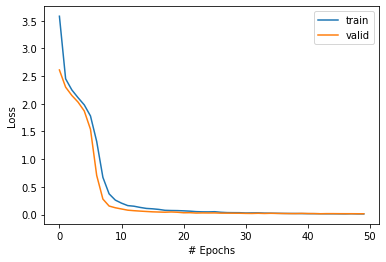